# ML Bootcamp for experienced software engineers: Part 1 - basics

This notebook is part 1 of a series, and it walks experienced engineers through the key basics of Machine Learning and training models.

1. Write `Back Propagation` and `Gradient Descent` algorithm in a `Tensor` library from stratch.
2. Write a `Neural Network` using our `Tensor` library.
3. This notebook then introduces you to a simple genuine Pytorch ML Model.
4. We prove our concepts' utility, by using them as replacements within the genuine Pytorch ML Model.

## How to run this code:

Please follow [the instructions to install conda](https://docs.conda.io/projects/conda/en/stable/user-guide/install/index.html)
```
# then create a fresh conda environment
conda create --name ml-bootcamp
conda activate ml-bootcamp

# install the necessary dependencies
conda install pytorch torchvision cpuonly -c pytorch
conda install notebook matplotlib

# open the notebook, within this you can click "run"
jupyter notebook
```

In the future we will cover additional topics necessary for you to participate in modern ML development.

## Citing Sources
Much of this content comes from [Andrej Karpathy's excellent "building micrograd" talk](https://youtu.be/VMj-3S1tku0). Most of the `MyTensor` corresponds to `Value` class and `NeuralNetwork` comes almost wholesale.


# Introducing the key concepts

## Tensor
A `Tensor` is just a class that wraps basic python types, like ints, floats, and strings.
Adding, multiplying, and other math ops build up graphs of `Tensor` with some parent `Tensor` node representing the function.

We call `Gradient Descent` on the parent `Tensor` node of the graph to compute a gradient. In doing so, we determine how to optimize the function for one small nudge.

See below how we compute a basic function with a parent node, and then compute the gradient and apply it to the leaf nodes. This optimizes the whole function.

In [1]:
"""
# Tensor in action

Here we build up a small equation of pytorch Tensors.

We call pytorch "backward" to compute the gradient of the simple function. 
Then we can see the gradient attribute set on the leaves of the function graph.
This gradient attribute allows us to change those leaves and optimize the whole function.
"""
import torch

# Building up the function from leaves
x = torch.tensor(-0.5, requires_grad=True)
y = torch.tensor(0.8, requires_grad=True)

# What pytorch tracks:
#    z 
#  /   \
# x*x  y

z = x*x + y

# We call `backward` to do back propagation once, which computes gradients.
z.backward()

# now x and y have their gradients set in `x.grad` and `y.grad`.

# we can use those gradients to "improve" x and y, in order to lower Z

# Subtract a little bit of the gradient from each leaf.
x2 = x.clone() - 0.01 * x.grad
y2 = y.clone() - 0.01 * y.grad
z2 = x2*x2 + y2

# z2 will be less than z1 now!
print(z.item(), z2.item())

1.0499999523162842 1.0300999879837036


## Back Propagation

Back Propagation is a graph algorithm that applies the chain rule to build up derivative relationships from parent to child. It propogates appropriately through each math operator node (which someone wrote). Then each leaf has a `grad` value set which is the derivative of the whole function with respect to that leaf node.

Remember, Tensors are a wrapper class holding values (typically floats). Modelers combine these tensors together to create mathematical expression trees which ultimately produce some desired value.  

In our case above the expression was:
$ z = x^2 + y $

and our values $x$ and $y$ combine with multiplcation and addition to produce $z$.

This is a differentiable function with inputs $x$ and $y$. 
We can compute the gradient at any point with math, with respect to each of these inputs.

$ \frac{\partial}{\partial x}(x^2 + y) = 2x $

and

$ \frac{\partial}{\partial y}(x^2 + y) = 1 $

The gradient, $(-1, 1)$ _is_ the update we need to apply to pick better $x$ and $y$ if we're starting at $(-0.5, 0.8)$

What pytorch does with back propagation, is _automate this_ differentiation as a _graph operation_ so we can build up arbitrary models, and run training to _repeatedly_ pick better values $x$, $y$, ..., so the model "trains" and becomes useful. 

## Gradient Descent

Gradient Descent is a mathematical algorithm which optimizes a function based on its derivative, in small steps.
In pytorch we repeatedly apply back propagation to conduct back propagation. Gradient descent doesn't need to apply to Machine Learning, however. We will show how to optimize our example function above using `Gradient Descent`:

![gradient_descent](./gradient_descent.png)

While you're actively running and understanding this code - I recommend watching [3blue1brown's series visualizing and explaining Gradient Descent](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).



## Machine Learning Models
From our perspective Machine Learning models are graphs/functions built up from `Tensor`s, and the output of the model is the function's output.





# Let's start writing a Tensor!
Now let's get to writing some code for a `Tensor` class, `Gradient Descent` and `Back Propagation`.



## What to note for later
You probably noticed the `requires_grad`. We'll see this more in the future.

Some inputs have to come from your business problem and it wouldn't make sense for the model to optimize those.

For instance we might predict a user's preference for an ad as $z$, and let the model optimize $x$, but $y$ would be the age of a user.

This will become clearer with more real world models.

In [2]:
import collections
import math

from dataclasses import dataclass, field
from typing import Callable, List, Optional


@dataclass
class MyTensor:
    """
    Tensor basically means thing with values in it. We'll restrict
    ourselves to single values in our tensors for learning purposes. 
    Pytorch Tensors actually hold n dimensional arrays of values,
    to take advantage of parallel compute resources.

    This class wraps individual float values, and allows us to call
    * add
    * multiply
    on these values to build up a long equation.
    
    Then, we can call `backward` to compute and populate the gradient
    all the way back through this graph.

    We represent parent/child relationships with edges in a graph.
    Those edges are tracked in `args`
    """
    data: float
    
    # argument `MyTensor`s, e.g. z = MyTensor(3.0) * MyTensor(2.0)
    # args = [Value(3.0), Value(2.0)]
    args: List["MyTensor"] = field(default_factory=list)

    # grad_fn is a function that _the parent function MyTensor_ will call
    # and pass in the gradient of that function with respect to this value.
    # The recursive graph call exactly matches how the chain rule applies.
    #
    # Consider an example:
    # This `MyTensor` instance is the function `f` and the parent node is `l`.
    # 
    # Then the logical function is l(f(x, y)), and f(x, y) = x * y
    # (or it could be f(x, y) = x + y, since `MyTensor` had multiplication and addition)
    # 
    # The user invoked `backward` on `l`, or even one of `l`'s parents.
    # All we need to know, is `l` called `grad_fn` and passed dl/df, in the argument, `grad`.
    # 
    # When we define `grad_fn` we need to compute loss with respect to inputs, `x`, and `y`.
    # and we need to update the `grad` field on those inputs.
    # 
    # x.grad = dl/dx = dl/df * df/dx
    # y.grad = dl/dy = dl/df * df/dy
    # 
    # if f = x * y, what are df/dx, and df/dy? Look at each operation and you will see that we know this
    # at compile time!
    # 
    grad_fn: Callable = lambda grad: None
    
    # This is where the gradient gets stored after back propagation.
    #
    # Note that the gradient on this `MyTensor`
    # is _with respect to_ some other parent `MyTensor`
    # that was higher up in the math function. Otherwise without any graph, df/df = 1.
    #
    # By _some other parent `MyTensor` we mean,
    # if the function is f(g(h(x, y))) and this value is h
    # then backward may have been called on f, _or g_, or even h
    # then `grad` would be df/dh, dg/dh, or dh/dh respectively.
    grad: float = 0

    def __eq__(self, o):
        """
        Two Values are equal if they have the same float.
        Also you can compare a Value to a plain float because that's convenient.
        """
        if isinstance(o, MyTensor):
            o = o.data
        if not isinstance(o, float):
            return False
        return math.isclose(self.data, o)

    def __add__(self, o) -> "MyTensor":
        def grad_fn(grad):
            self.grad += grad
            o.grad += grad

        # You can add a float to a tensor
        # and we'll wrap it for convenience.
        if not isinstance(o, MyTensor):
            o = MyTensor(o)

        return MyTensor(data = self.data + o.data, args=[self, o], grad_fn=grad_fn)

    def __mul__(self, o) -> "MyTensor":
        def grad_fn(grad):
            """
            we need to compute loss with respect to inputs, `x`, and `y`.

            x.grad = dl/dx = dl/df * df/dx
            y.grad = dl/dy = dl/df * df/dy

            if f = x * y, what are df/dx, and df/dy?
            See the code below!

            """
            # raise Exception("you need to implement this")
            self.grad += grad * o.data
            o.grad += grad * self.data

        if not isinstance(o, MyTensor):
            o = MyTensor(o)
        return MyTensor(data = self.data * o.data, args=[self, o], grad_fn=grad_fn)
    
    def relu(self) -> "MyTensor":
        """
        We will need one quirky operation, a "Rectified Linear Unit".
        This will be our "non linearity":
        * which goes in between "linear" (add and multiply) operations to increase
            out models function domain, and
        * which is still _essentially_ differentiable,

        For the surprising flexibility of neural networks with non-linearities,
        see the https://en.wikipedia.org/wiki/Universal_approximation_theorem

        If there is a competition for making simple things intimidating,
        ReLU should be a top contender.
        
        ReLU is just f(x) = max(x, 0)
        """
        def grad_fn(grad):
            return max(grad, 0)
        return MyTensor(data = max(self.data, 0), args=[self], grad_fn=grad_fn)
    

    def backward(self, grad=1) -> None:
        """
        Do back propagation from this `MyTensor` to its leaf nodes!
        
        This value presumabl has a graph of predecessors, or else not much happens.
        
        All those predecessors will now get their grad set w.r.t this `MyTensor`.
        Backward will compute grad_fn working back from this `MyTensor` to
        all the leaves.
        """
        # gradient with respect to myself is 1.
        # dl/dl = 1
        self.grad = 1

        queue = collections.deque([self])
        while queue:
            node = queue.popleft()
            node.grad_fn(node.grad)
            queue.extend(node.args)


In [3]:
import unittest

class TestAutoGrad(unittest.TestCase):
    """
    Run these test cases to make sure your update works
    """
    def tensor(self, x: float, **kwargs):
        # Try replacing MyTensor with torch.tensor. The results should be the same!
        # return torch.tensor(x, **kwargs)
        return MyTensor(x)

    def test_math_without_grad(self):
        # Test that regular math works
        self.assertEqual((self.tensor(3.0) * self.tensor(2.0) + self.tensor(5.0)), 11.0)
        self.assertNotEqual((self.tensor(3.0) * self.tensor(2.0) + self.tensor(5.0)), 12.0)
    
    def test_simple_gradient(self):
        c = self.tensor(3.0, requires_grad=True)
        x = self.tensor(5.0)
        o = c * x

        o.backward()
        self.assertEqual(c.grad, x)

    def test_our_example_function(self):
        x = self.tensor(-0.5, requires_grad=True)
        y = self.tensor(0.8, requires_grad=True)
        o = (x*x) + y

        o.backward()
        self.assertEqual(x.grad, -1.0)
        self.assertEqual(y.grad, 1.0)
    
    
    def test_aggregated_gradient(self):
        # If a `MyTensor` has two parents then
        # the gradient has contributions from both.
        
        c = self.tensor(3.0, requires_grad=True)
        x = self.tensor(5.0)
        y = self.tensor(7.0)
        o = (c*x) + (c*y)
        o.backward()
        self.assertEqual(c.grad, (x+y))

    def test_layered(self):
        w1 = self.tensor(3.0, requires_grad=True)
        w2 = self.tensor(5.0, requires_grad=True)
        w3 = self.tensor(7.0, requires_grad=True)

        a = self.tensor(37.0)
        b = self.tensor(43.0)

        x1 = self.tensor(11.0)
        x2 = self.tensor(13.0)
        x3 = self.tensor(17.0)
        x4 = self.tensor(19.0)
        x5 = self.tensor(23.0)
        x6 = self.tensor(27.0)

        o = a * ((w1 * x1) + \
        (w2 * x2) + \
        (w3 * x3)) + \
        b * ((w1 * x4) + \
        (w2 * x5) + \
        (w3 * x6))
        
        o.backward()
        self.assertEqual(w1.grad, a*x1 + b*x4)
        self.assertEqual(w2.grad, a*x2 + b*x5)
        self.assertEqual(w3.grad, a*x3 + b*x6)


unittest.main(argv=[""], verbosity=2, exit=False)

test_aggregated_gradient (__main__.TestAutoGrad.test_aggregated_gradient) ... ok
test_layered (__main__.TestAutoGrad.test_layered) ... ok
test_math_without_grad (__main__.TestAutoGrad.test_math_without_grad) ... ok
test_our_example_function (__main__.TestAutoGrad.test_our_example_function) ... ok
test_simple_gradient (__main__.TestAutoGrad.test_simple_gradient) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.002s

OK


# Gradient Descent on our simple function using MyTensor and Back Propagation

In [4]:
# We can repeatedly backpropagate and slight "improve" x and y, to greatly reduce z.

x, y = MyTensor(-0.5), MyTensor(0.8)

# tracking these separately will make graphing easier.
x_history, y_history, z_history = [], [], []
 
# We want to pick a small multiple of the gradient
# to keep the steps reasonable.
learn_rate = 0.05
def F(x, y):
    return x*x + y
    
for i in range(10):
    z = F(x, y)
    x_history.append(x.data)
    y_history.append(y.data)
    z_history.append(z.data)
    z.backward()
    x = MyTensor(x.data - learn_rate * x.grad)
    y = MyTensor(y.data - learn_rate * y.grad)


print(x_history)
print(y_history)
print(z_history)

[-0.5, -0.45, -0.405, -0.36450000000000005, -0.32805000000000006, -0.29524500000000004, -0.2657205, -0.23914845, -0.215233605, -0.1937102445]
[0.8, 0.75, 0.7, 0.6499999999999999, 0.5999999999999999, 0.5499999999999998, 0.49999999999999983, 0.44999999999999984, 0.39999999999999986, 0.34999999999999987]
[1.05, 0.9525, 0.864025, 0.7828602499999999, 0.7076168024999999, 0.6371696100249998, 0.5706073841202498, 0.5071919811374024, 0.4463255047212959, 0.38752365882424966]


# Gradient Descent Optimizes our Function
By choosing small updates based on the gradient, 
our function slowly produces minimized outputs.

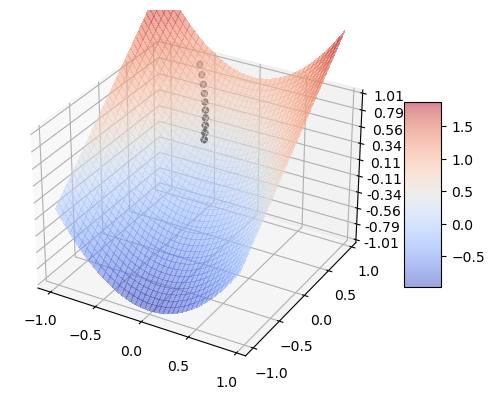

In [5]:
# This cell plots the gradient descent values we collected.

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, alpha=0.5, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.scatter(x_history, y_history, z_history, color='black', zorder=10)
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Writing our own Neural Network based on MyTensor

You'll see below that a Neural Network is basically just a series of additions, multiplications, in a graph of `MyTensor`. Gradient Descent is the real "secret sauce".

The only surprising addition is the "non-linearity", Rectified Linear Unit (ReLU) which is `relu(x) = max(x, 0)`. 

When we apply a "non-linearity" (see the comment in MyTensor.relu) on top of otherwise linear (add, multiply) operations, and apply gradient descent, we have a broadly applicable and differentiable function approximator!

Broadly applicable is obviously good. Differentiable means we can improve the
function using gradient descent.

## Attribution:
This code is basically exactly the same as:
https://github.com/karpathy/micrograd/blob/master/micrograd/nn.py
"""


In [6]:
import random
from typing import List

def randomized_value():
        return MyTensor(random.uniform(-1, 1))

class Module:
    """
    This just gives us the ability to reset gradients.
    """

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def parameters(self) -> List[MyTensor]:
        """
        Each "Module" needs to return a list of MyTensor which
        should be included in "resetting".
        """
        raise Exception("This is expected to be implemented in Modules")


class Neuron(Module):
    """
    A Neuron has it's own "weights", and a "bias" which are `MyTensor` values to optimize.
    It also accepts inputs from your problem domain - which won't be optimized.
    The output is:
    
    weight * input + bias
    
    Then we apply the "non-linearity" to give the model more expressive power.
    """
    def __init__(self, input_len: int):
        self.weights = [randomized_value() for _ in range(input_len)]
        self.bias = randomized_value()
    
    def __call__(self, input):
        if len(input) != len(self.weights):
            raise Exception(f"got input of length{len(input)}, expected input of length {len(self.weights)}")
        output = sum((w * i for (w, i) in zip(self.weights, input)), self.bias)
        return output.relu()
    
    def parameters(self) -> List[MyTensor]:
        return self.weights + [self.bias]

class Layer(Module):
    """
    This is an array of Neurons.
    """
    
    def __init__(self, num_inputs: int, num_outputs: int):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
    
    def __call__(self, inputs):
        return [neuron(inputs) for neuron in self.neurons]
     
    def parameters(self) -> List[MyTensor]:
        return [p for n in self.neurons for p in n.parameters()]

class MultiLayerPerceptron(Module):
    """
    This is an array of Layers.
    """
    def __init__(self, input_len: int, layer_output_lens: List[int]):

        self.layers = []
        for output_len in layer_output_lens:
            self.layers.append(Layer(input_len, output_len))
            input_len = output_len

    def __call__(self, inputs):
        out = inputs
    
        for layer in self.layers:
            out = layer(out)

        return out
     
    def parameters(self) -> List[MyTensor]:
        return [p for l in self.layers for p in l.parameters()]

print(Neuron(3)([1]* 3))
print(Layer(3, 2)([1]*3))
print(MultiLayerPerceptron(3, [2, 3])([1]*3))
MultiLayerPerceptron(3, [2, 3]).zero_grad()

MyTensor(data=1.911865958564714, args=[MyTensor(data=1.911865958564714, args=[MyTensor(data=1.1578334762439764, args=[MyTensor(data=1.038780040503263, args=[MyTensor(data=0.2571998746833186, args=[], grad_fn=<function MyTensor.<lambda> at 0x7efeb058bd80>, grad=0), MyTensor(data=0.7815801658199444, args=[MyTensor(data=0.7815801658199444, args=[], grad_fn=<function MyTensor.<lambda> at 0x7efeb058bd80>, grad=0), MyTensor(data=1, args=[], grad_fn=<function MyTensor.<lambda> at 0x7efeb058bd80>, grad=0)], grad_fn=<function MyTensor.__mul__.<locals>.grad_fn at 0x7efea7aca480>, grad=0)], grad_fn=<function MyTensor.__add__.<locals>.grad_fn at 0x7efea7aca020>, grad=0), MyTensor(data=0.11905343574071336, args=[MyTensor(data=0.11905343574071336, args=[], grad_fn=<function MyTensor.<lambda> at 0x7efeb058bd80>, grad=0), MyTensor(data=1, args=[], grad_fn=<function MyTensor.<lambda> at 0x7efeb058bd80>, grad=0)], grad_fn=<function MyTensor.__mul__.<locals>.grad_fn at 0x7efea7aca520>, grad=0)], grad_fn=

# Let's now see how our MultiLayerPerceptron matches up with Pytorch

1. We'll follow [the pytorch quickstart tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
2. we'll come back and drop in our own `MyTensor` based Neural Network, and see that the output is "the same". 

Realistically our code is going to be enormously slower than Pytorch. Likely you won't have the patience to see more than a few iterations of back propogation with our Neural Network on even the small example ML Model.

In [7]:
# Cell 1 from the pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [8]:
# Cell 2 from the pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# What is training data?
We downloaded the "fashion-mnist" dataset and it's now a file on your computer.
> Answer yourse: How big is the file?

This file is a list of input images for ML Models, and labels.
The training data is _critical_. The model will "learn" from this data.
The labels "teach" the model what good outputs look like.

> Look at https://github.com/zalandoresearch/fashion-mnist. How many different labels are there for “fashion-mnist”?

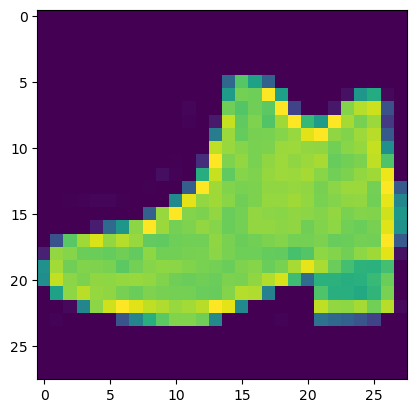

In [9]:
plt.imshow(training_data[15][0][0])

> Can you find the label for the index 15 item in the dataset?
> We displayed the image above, does it makes sense with the label?  

In [10]:
# Here's the label
training_data[15][1]

9

In [11]:
# (modified) Cell 3 from the pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
train_dataloader = DataLoader(training_data)
test_dataloader = DataLoader(test_data)

# It's pretty common to literally iterate through the dataset.
# Typically it's done in "batches" to take advantage of compute parallelism.


for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64


# Writing a "real" pytorch model!

In [12]:
# (modified) Cell 4 from the pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        """
        You saw that the images are 28x28 arrays.
        So we need to call `flatten` to produce a (28*28=784) long array.
        After that we're using Linear layers followed by ReLUs which have
        the same mathematical effect as our Layers!.
        """
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """
        `forward` is part of the pytorch interface.
        This is just calling the model on the input x.
        """
        x = self.flatten(x)
        # logits is basically a fancy word for "raw outputs"
        # ML scientists like words that sound scientific.
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Then there's "boilerplate"
While pytorch makes it easy to define a model,
the training loop code can quickly become complicated in the real world.
We'll stick to the example from the pytorch tutorial, but know
that you should expect to see:
* compute and data sharding,
* multi machine GPU parallelism, 
* distributed and cursor aware checkpointing, 
* telemetry and validation code
among many other "big scale" components in this boiler plate.


In [13]:
# (modified) Cells 5,6,7 from the pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# I glossed over "loss functions" and we will cover this more later.
# Know that loss functions basically wrap your neural net 
#   to compare the model's output with the desired output:
#
# loss(input, output) `abs(neural_net(input) - expected_output)`
#
# So when gradient descent optimized _from_ this wrapper function's node
# your neural net is _improving_ the weights in terms
# of creating desirable outputs.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Epoch means dataset pass.
# Like two epochs means two entire passes through the dataset.
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.370152  [    1/60000]
loss: 0.198890  [10001/60000]
loss: 0.049743  [20001/60000]
loss: 0.031128  [30001/60000]
loss: 0.423391  [40001/60000]
loss: 0.202370  [50001/60000]
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.502760 

Epoch 2
-------------------------------
loss: 0.013136  [    1/60000]
loss: 0.009967  [10001/60000]
loss: 0.002747  [20001/60000]
loss: 0.038136  [30001/60000]
loss: 0.270433  [40001/60000]
loss: 0.257043  [50001/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.441821 

Epoch 3
-------------------------------
loss: 0.002387  [    1/60000]
loss: 0.008822  [10001/60000]
loss: 0.001419  [20001/60000]
loss: 0.027906  [30001/60000]
loss: 0.197916  [40001/60000]
loss: 0.254639  [50001/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.410322 

Epoch 4
-------------------------------
loss: 0.001092  [    1/60000]
loss: 0.005221  [10001/60000]
loss: 0.001085  [20001/60000]
loss: 0.024402  [30001/60000]
loss: 0.154382  [40001/6

# This is a working trained pytorch model!
You could use this in a fashion app.

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Let's train our MultiLayerPerceptron on the same data!

In [15]:
class MyImageClassifier:
    def __init__(self):
        self.nn = MultiLayerPerceptron(28*28, [512, 512, 10])
    
    def forward(self, x):
        """
        x will be a 28x28 array.
        So we'll use a convenient pytorch thing to flatten it to a 1d array.
        """
        # x = torch.flatten(x)
        x = torch.flatten(x).tolist()
        return self.nn(x)
    

example_input = training_data[15][0]
y = MyImageClassifier().forward(example_input)
print([t.data for t in y])




[343.33820873735186, 0, 0, 52.728456195397875, 290.188938110364, 1207.2769454915845, 0, 1343.414522512441, 227.96530423728888, 212.96803845325275]


In [16]:
# We're going to use this to define a quick and dirty "loss function".
torch.nn.functional.one_hot(torch.tensor([9]), 15).tolist()[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [ ]:
train_rate = 0.01
def train(dataloader, model):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model.forward(X)
        def myloss(predicted_labels, label):
            expected_labels = torch.nn.functional.one_hot(torch.tensor(label), 15).tolist()[0]
            return sum((pred_label + (-1 * exp_label) for (pred_label, exp_label) in zip(predicted_labels, expected_labels)), MyTensor(0))

        loss = myloss(pred, y)

        # Backpropagation
        loss.backward()

        for p in model.nn.parameters():
            p.data -= train_rate * p.grad
        model.nn.zero_grad()
        print(f"loss: {loss.data:>7f}", flush=True)


model = MyImageClassifier()

# This takes hours for even one back propagation :/
train(train_dataloader, model)

/tmp/ipykernel_23257/1337800516.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_labels = torch.nn.functional.one_hot(torch.tensor(label), 15).tolist()[0]
